In [15]:
import pickle
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Camera Calibration

Multiple images of a 9X6 chessboard was used to calibrate teh camera.

cv2.findChessboardCorners to locate corners in the images. 

These points were then mapped to a a unifrom 9X6 Mesh giving us a undistortion factor for each point in the image. 

This is done to account for camera characteristics that warp and compress images along its edges


In [16]:
#Camera Calibration
#import all images
images = glob.glob('camera_cal/calibration*.jpg')

#Dimensions of Chessboards used
nx = 9
ny = 6

objpoints = []
imgpoints = []

#Initializing a 9X6 uniform grid
objp = np.zeros((ny*nx,3),np.float32)
objp[:,:2]=np.mgrid[0:nx,0:ny].T.reshape(-1,2)

#looking at each image and extracting the corners from each of them
for fname in images:
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    #print(ret)
    if ret == True:
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
        imgpoints.append(corners)
        objpoints.append(objp)
        cv2.drawChessboardCorners(img, (nx,ny), corners, ret)
        
#Funtion called Unditort is then used after this to cahnge the 
#camera image to an undistorted image


# Undistort

This function takes in an array of points representing a grid in a distorted image and also a unifor undistorted grid adn then converts a distorted image into an undistorted one

cv2.calibrateCamera - Computes the transformation matrices
cv2.undistort - Uses the transformation matrix to convert a distorted image into an undistorted image

In [17]:
# Funtion to undistort
def undistort(img, objpoints, imgpoint):
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist
#returns an undistorted image

# Warping

Every image taken from a camera is subject to warping. Things near the camera look bigger and things farther away from the camera look smaller.

This is why the road in from looks like a trapezoid even though it is actualy a rectangle. 

Thus the default view from a camera is not good enough to estimate lane parameters such as curvature, lateral distance between lanes. 

Thus the image is converted to a top view image such taht we are looking at the road from up above. 

In this view we can easily estimate radius of curvaure and also determing how far from the center of the lane the car is.

This is done using two functions:
1. Regionmask - This is used to define a region in which would actually represent a rectang when viewed from teh top. 
2. Warp - This function is used to take two sets of data and then form a transformation matrix to convert the image from teh default camera view to one of looking form up above. 


## Warp Function

This function takes in a matrix of what should be a rectangle in the default view and also a matrix of where this rectangle should eb in the new view.

This function then generates a matrix to convert warp teh image and change it so taht we were looking from a birds eye perspective. 

This funstion also finds an inverse matrix to convert from this 'birds eye view' back to the default camera view


In [18]:
# Used to define a rectangle region in a warped Image
def regionmask(image,x1,y1y4,x2,y2y3,x3,x4):
    """Function to define a region of interest to look for lane lines in the image/video"""
    #Extract image size
    Y = image.shape[0]
    X = image.shape[1]
    region = np.array([[[x1,y1y4],[x2,y2y3],[x3,y2y3],[x4,y1y4]]])
    return(Y,X,region)

# Used to find transformation matrix form Camera view to Birds eye view 
# and also the inverse of this
def warp(undist_img,X,Y,region):
    src = np.float32([region[0,0],region[0,1],region[0,2],region[0,3]])
    #print(src)
    d = 290
    dst = np.float32([[d,720],[d,0],[X-d,0],[X-d,720]])
    #print(dst)
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(undist_img, M, (X,Y),flags = cv2.INTER_NEAREST)
    return warped,M,Minv

# Thresholding to identify lanes

Different methods were used to try adn identify the lane lines. Thresholding identifies a certain paramter on the image and then creates a binary version of this by selecting all the points that fall within a ranage for the defined parameter.

For example if Rmax is set to 100 and Rmin is set to 0. Then the RGB information is extrated from the image and Rbin is created for all point that fall within the range of 0 -100 as true.

The list of Different methods of thresholding used are as follows

1. Sobelx - Change in gradient in X direction
2. Sobely - Change in gradient in Y direction
3. Sobel Magnitude - Used to take a square root of the sum of squares of sobelx and sobely. This gives us an absolute magnitude of the vector of change for a point defined by both the y direction and x direction
4. Sobel Direction - This takes the tan inverse of sobely/sobelx. This is a quantification of the direction of the vector of change for a point defined by both the y direction and x direction 
5. Soble combined - A combination of the above factors was used. Different combinations were tried such as sobelx and Magnitude. Or the one that was ultimately used which is (sobelx&sobely)|(Direction and Magnitude

In [31]:
#Sobel Threshholds
def abs_sobel_thresh(img, xmin,xmax,ymin,ymax, kernel):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = kernel)
    abs_sobelx = np.absolute(sobelx)
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    sobelxbin = np.zeros_like(scaled_sobelx)
    sobelxbin[(scaled_sobelx >= xmin) & (scaled_sobelx <= xmax)] = 1
    
    
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = kernel)
    abs_sobely = np.absolute(sobely)
    scaled_sobely = np.uint8(255*abs_sobely/np.max(abs_sobely))
    sobelybin = np.zeros_like(scaled_sobely)
    sobelybin[(scaled_sobely >= ymin) & (scaled_sobely <= ymax)] = 1
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image # Remove this line
    return sobelxbin, sobelybin, sobelx, sobely

#Gradient
def sobel_magnitude(sobelx,sobely,magmin,magmax):
    mag = np.sqrt(sobelx*sobelx+sobely*sobely)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    magbin = np.zeros_like(scaled_mag)
    magbin[(scaled_mag >= magmin) & (scaled_mag <= magmax)] = 1
    return magbin,mag

def sobel_direction(sobelx,sobely,thetamin,thetamax):
    direction = np.arctan2(sobely,sobelx)
    thetabin = np.zeros_like(direction)
    thetabin[(direction >= thetamin) & (direction <= thetamax)] = 1
    return thetabin,direction

def sobel_combined(sobelxbin,sobelybin,thetabin,magbin):
    combinedbin = np.zeros_like(thetabin)
    combinedbin[((sobelxbin==1)&(sobelybin==1))|((thetabin == 1) & (magbin==1))] = 1
    return combinedbin



# Colour Space
Different colourspaces and different threshold for all components were used to determine hte best way to identify lane lines. Different colourspaces were good at determining different lane line features

The colour spaces used are as follows:
1. RGB - Good to identify colour information in different images
2. HLS - Good to identify lane lines during different lighting conditions
3. LAB - Goot to identify yellow lane lines

The above observations are just based ons ome of the testing taht I had done for different images and sections fo the video

These colourspaces Thresholds were then combined with gradient thresholds to generate the final lane identification


In [20]:
#RGB
def RGB_Thresh(warped,thresh):
    R = warped[:,:,0]
    G = warped[:,:,1]
    B = warped[:,:,2]
    Rbin = np.zeros_like(R)
    Rbin[(R >= thresh[1]) & (R <= thresh[0])] = 1
    Gbin = np.zeros_like(G)
    Gbin[(G >= thresh[3]) & (G <= thresh[2])] = 1
    Bbin = np.zeros_like(B)
    Bbin[(B >= thresh[5]) & (B <= thresh[4])] = 1
    
    return R,G,B,Rbin,Gbin,Bbin

#HLS
def HLS_Thresh(warped,thresh):
    hls = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    Hbin = np.zeros_like(H)
    Hbin[(H >= thresh[1]) & (H <= thresh[0])] = 1
    Lbin = np.zeros_like(L)
    Lbin[(L >= thresh[3]) & (L <= thresh[2])] = 1
    Sbin = np.zeros_like(S)
    Sbin[(S >= thresh[5]) & (S <= thresh[4])] = 1
    
    return H,L,S,Hbin,Lbin,Sbin

#LAB
def LAB_Thresh(warped,thresh):
    lab = cv2.cvtColor(warped, cv2.COLOR_RGB2Lab)
    LabL = lab[:,:,0]
    LabA = lab[:,:,1]
    LabB = lab[:,:,2]
    LabLbin = np.zeros_like(LabL)
    LabLbin[(LabL>= thresh[1]) & (LabL <= thresh[0])] = 1
    LabAbin = np.zeros_like(LabA)
    LabAbin[(LabA >= thresh[3]) & (LabA <= thresh[2])] = 1
    LabBbin = np.zeros_like(LabB)
    LabBbin[(LabB >= thresh[5]) & (LabB <= thresh[4])] = 1
    
    return LabL,LabA,LabB,LabLbin,LabAbin,LabBbin



# Combination
A few combinations of both the feature thresholds and the colour thresholds were used to identify the best approach to identify lane lines.

the combination used ultimated is ((L(hls)&(R)(RGB))|(B(Lab))

In [21]:
def combinationtest(warped,Lbin,Rbin,sobelxbin,thetabin,LabBbin):
    testbin = np.zeros_like(Lbin)
    # testbin[((Lbin == 1)&(Rbin == 1))|(sobelxbin == 1)&(thetabin == 1)|(LabBbin == 1)] = 1
    # testbin[((Lbin == 1)|(LabBbin == 1))] =1
    testbin[((Lbin == 1)&(Rbin == 1))|(LabBbin == 1)] = 1
    return testbin

# Finding beginning of lane lines
Once tthe lanes are identified in the previous step, a histogram of the lower half of the image was plotted to identify the starting x coordinate of the lane lines.

In [22]:
def histogramcheck(testbin):
    histogram = np.sum(testbin[testbin.shape[0]//2:,:], axis=0)
    histogrambin = np.zeros_like(histogram)
    histogrambin[(histogram>25)]=1
    # center = np.int(histogrambin.shape[0]//2)
    # baseL = np.argmax(histogrambin[0:center])
    # baseR = np.argmax(histogrambin[center:histogrambin.shape[0]])+center
    center = np.int(histogram.shape[0]//2)
    baseL = np.argmax(histogram[0:center])
    baseR = np.argmax(histogram[center:histogram.shape[0]])+center
    
    return center,baseL,baseR,histogrambin,histogram

# Sliding window fit

In this section, a sliding window of a defined width and height was placed at the beginning of the lane lines. 

It is then moved up along the image until it reaches the top edge. 

At each position only the points inside the box detected as lane lines are considered. 

If there are more than a threshold of points that were detected as lane lines within this window then we actually move the center of the next window to the mean of the current detected points. This way we our series of boxes can continuously track the lane lines even if they curve. 

In [33]:
# Funtion to define the sliding windows within which to look for lane points
def slidingwindowfit(warped,testbin,nwindows,window_width,lanethresh,lane,laney,lanex,cenL,cenR,Y):
    #height of each window
    window_height = np.int(warped.shape[0]/nwindows)
    
    indexL = []
    indexR = []
    indexcurL = []
    indexcurR = []


    windows = []
    
    #looping through the number of window checeking number of points and then deciding to move or not move the center
    for i in range(nwindows):
    #     print('Loop Number:',i)
    #     print('cenL',cenL)
    #     print('cenR',cenR)
    
    #Points for teh box
        xll = np.int(cenL - (window_width/2))
        #print(xll)
        xlr = np.int(cenL + (window_width/2))

        xrl = np.int(cenR - (window_width/2))
        xrr = np.int(cenR + (window_width/2))


        yb = Y-i*window_height
        yt = Y-(i+1)*window_height
        #print('xll',xll,'xlr',xlr,'xrl',xrl,'xrr',xrr,'yb',yb,'yt',yt)
        windows.append((yt,yb,xll,xlr,xrl,xrr))
        #print(window)
    
    #Index of the selected points are stored to be used further
        #Where in the images I haev lane lines 
        indexcurL = ((laney<yb)&(laney>=yt)&(lanex>xll)&(lanex<xlr)).nonzero()[0]
        indexL.append(indexcurL)
        #print(indexcurL)
        #print(len(indexcurL))
        indexcurR = ((laney<yb)&(laney>=yt)&(lanex>xrl)&(lanex<xrr)).nonzero()[0]
        indexR.append(indexcurR)
        #print(len(indexcurR))
        #print(indexcurR)
        
        #If number of points detected is ? a threshold then we move the center
        if len(indexcurL)>=lanethresh:
            #print('Entered Left')
            cenL = np.int(np.mean(lanex[indexcurL]))
        if len(indexcurR)>=lanethresh:
            #print('Entered Right')
            cenR = np.int(np.mean(lanex[indexcurR]))

    #print(indexL)
    indexL = np.concatenate(indexL)
    #print(indexL)
    indexR = np.concatenate(indexR)

    #Identifying coordinates for the lane to be used for polynomial fitting
    xL = lanex[indexL]
    yL = laney[indexL] 
    xR = lanex[indexR]
    yR = laney[indexR]

    #print(xL)
    #print(yL)
    #print(xR)
    #print(yR)

    fitL,fitR = (None,None)

    #Fitting a 2 degree polynomial to the points we detected
    if len(xL!=0):
        fitL = np.polyfit(yL,xL,2)
    if len(xL!=0):
        fitR = np.polyfit(yR,xR,2)
        
    return fitL,fitR,windows,indexL,indexR,xL,yL,xR,yR

# Radius of curvature calculation

I did the exact calculation that were provided in the course material.

I converted all my pixel values to m and then fit a new polynomial onto it. 

Also the radius of curvature was measure at the bottom most point or the highest Y

In [34]:
def radiusofcurvatrue(yL,xL,yR,xR):
    y_eval = 719
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(yL*ym_per_pix,xL*xm_per_pix,2)
    right_fit_cr = np.polyfit(yR*ym_per_pix, xR*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    curverad = (left_curverad+right_curverad)/2 
    return left_curverad,right_curverad,curverad,xm_per_pix

# Distance from Center
This calculation was relatively easy. 

We had already calculated the base of the left nad right lanes. 

I then took this values to find the mid point of the lane.

I then assumed the camera is mounted bang int eh center of the car and thus 1280/2 = 640 should be the lane center when the car is perfectly centered. 

I just subtracted the calculated lane center from 640 to get the deviation 

This was then printed on teh final image. 

In [35]:
def centerdist(baseR,baseL,xm_per_pix):
    distfromcenter = ((baseR-baseL)/2+baseL-640)*xm_per_pix
    return distfromcenter

# PLotting lane lines back

Two functions were used for this purpose.

## drawlane 
Used to draw the detected lane lines based on the plynomial fit back on to the original image. A polynomial is drawn passing thorough three points according to the calculated fit. An inverse matrix of transformation is then used to move this from the 'birds eye view' tot he default camera view. This is then drawn on teh original image

## showdata
This function is then used to display the radius of curvature as well as distance from center as shown in the course videos. 

One consideration give to the distance from center was that according to the sign of the distance we printed left or right to show the direction of deviation as well
    

In [41]:
def drawlane(img, testbin, fitL, fitR, Minv,):
    new_img = np.copy(img)
    if fitL is None or fitR is None:
        return img
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(testbin).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    h,w = testbin.shape
    ploty = np.linspace(0, h-1, num=h)# to cover same y-range as image
    fitxL = fitL[0]*ploty**2 + fitL[1]*ploty + fitL[2]
    fitxR = fitR[0]*ploty**2 + fitR[1]*ploty + fitR[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    ptsL = np.array([np.transpose(np.vstack([fitxL, ploty]))])
    ptsR = np.array([np.flipud(np.transpose(np.vstack([fitxR, ploty])))])
    pts = np.hstack((ptsL, ptsR))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    cv2.polylines(color_warp, np.int32([ptsL]), isClosed=False, color=(255,0,255), thickness=15)
    cv2.polylines(color_warp, np.int32([ptsR]), isClosed=False, color=(0,255,255), thickness=15)

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (w, h)) 
    # Combine the result with the original image
    result = cv2.addWeighted(new_img, 1, newwarp, 0.5, 0)
    return result

def showdata(laneimg, curverad, distfromcenter):
    new_img = np.copy(laneimg)
    h = new_img.shape[0]
    font = cv2.FONT_HERSHEY_DUPLEX
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(curverad) + 'm'
    cv2.putText(new_img, text, (40,70), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    direction = ''
    if distfromcenter > 0:
        direction = 'right'
    elif distfromcenter < 0:
        direction = 'left'
    else:
        direction = 'middle'
    abs_center_dist = abs(distfromcenter)
    text = '{:04.3f}'.format(abs_center_dist) + 'm ' + direction
    cv2.putText(new_img, text, (40,120), font, 1.5, (200,255,155), 2, cv2.LINE_AA)
    return new_img

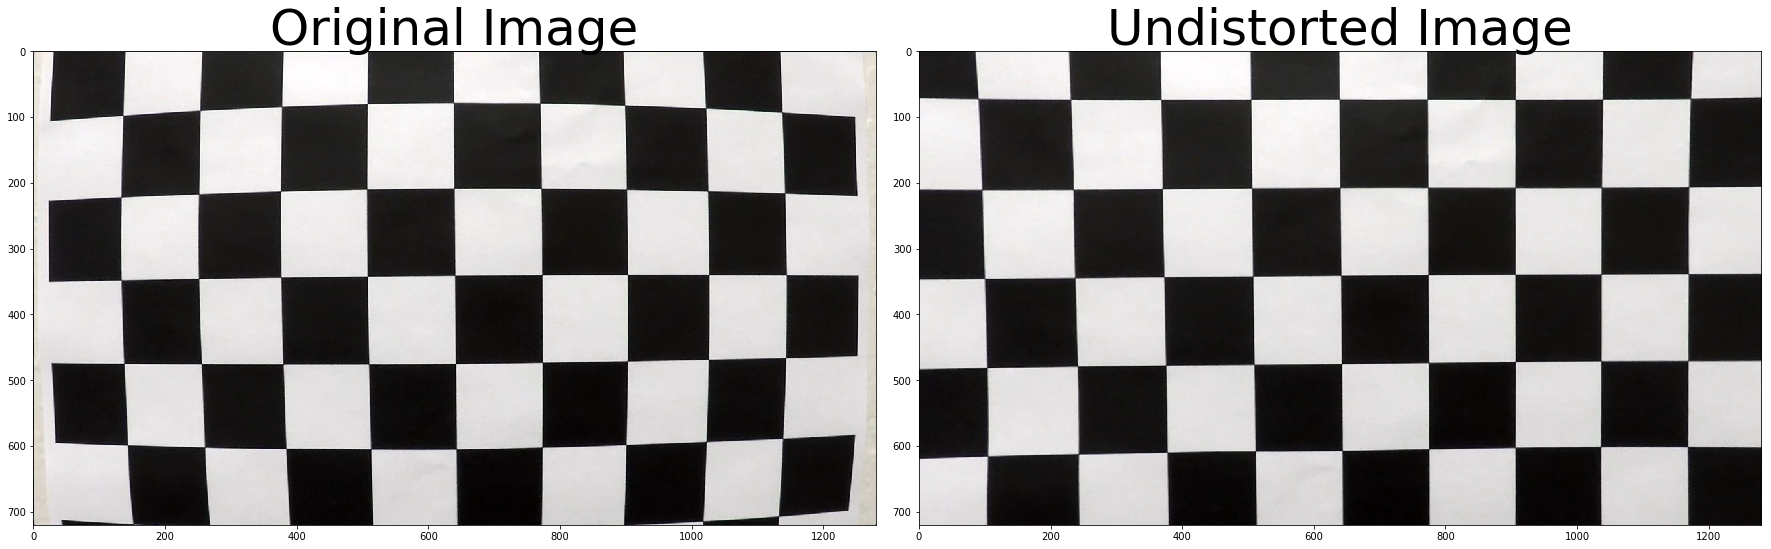

In [42]:
img = mpimg.imread('camera_cal/calibration1.jpg')
undist_img = undistort(img,objpoints,imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

# Pipeline

A pipeline is created to call all the above funtions as needed. The code for this pipeline also has all the thresholds used in the project. 

This pipeline was first applied to images. Different thresholds and also thresholding parameters observed and then looking at the different outputs combinations and thresholds were chosen.

In [43]:
def lanelinefind(img,objpoints,imgpoints):
    # undistort Image
    undist_img = undistort(img,objpoints,imgpoints)

    x1=210
    y1y4=710
    x2=595
    y2y3=450
    x3=685
    x4=1070
    Y,X,region = regionmask(undist_img,x1,y1y4,x2,y2y3,x3,x4)

    #warp images
    warped,M,Minv = warp(undist_img,X,Y,region) 

    #sobelthresholds
    xmin = 10 
    xmax = 100
    ymin = 150
    ymax = 255
    kernel = 15
    sobelxbin,sobelybin, sobelx, sobely = abs_sobel_thresh(warped,xmin,xmax,ymin,ymax,kernel)

    #SobelMagnitude
    magmin = 25
    magmax = 255
    magbin,mag = sobel_magnitude(sobelx,sobely,magmin,magmax)

    #SobelDirection
    thetamin = -1
    thetamax = 1
    thetabin,direction = sobel_direction(sobelx,sobely,thetamin,thetamax)

    #SobelCombined
    combinedbin = sobel_combined(sobelxbin,sobelybin,thetabin,magbin)

    #RGBThresh
    Rmax = 255
    Rmin = 180 
    Gmax = 255
    Gmin = 150 
    Bmax = 255
    Bmin = 120 
    thresh = (Rmax,Rmin,Gmax,Gmin,Bmax,Bmin)
    R,G,B,Rbin,Gbin,Bbin = RGB_Thresh(warped,thresh)

    #HLSThresh
    Hmax = 50
    Hmin = 0 
    Lmax = 255
    Lmin = 200
    Smax = 255
    Smin = 120
    thresh = (Hmax,Hmin,Lmax,Lmin,Smax,Smin)
    H,L,S,Hbin,Lbin,Sbin = HLS_Thresh(warped,thresh)

    #LABThresh
    LabLmax = 150
    LabLmin = 100
    LabAmax = 255
    LabAmin = 120
    LabBmax = 255
    LabBmin = 150
    thresh = (LabLmax,LabLmin,LabAmax,LabAmin,LabBmax,LabBmin)
    LabL,LabA,LabB,LabLbin,LabAbin,LabBbin = LAB_Thresh(warped,thresh)

    #Final
    testbin = combinationtest(warped,Lbin,Rbin,sobelxbin,thetabin,LabBbin)

    #Histogram Calculation - Lane Base detection
    center,baseL,baseR,histogrambin,histogram = histogramcheck(testbin)

    #sliding Window fit
    #number of windows to use
    nwindows = 10
    
    #width of windows
    window_width = 200
    
    #Number of points to eb detected ina  window before the center can eb moved
    lanethresh = 50
    
    
    lane = testbin.nonzero()
    laney = np.array(lane[0])
    lanex = np.array(lane[1])
    # laney = np.array([500,600,100,200,500,600,100,200])
    # lanex = np.array([250,1020,270,1050,260,1030,280,1060])

    cenL = baseL
    cenR = baseR
    fitL,fitR,windows,indexL,indexR,xL,yL,xR,yR = slidingwindowfit(warped,testbin,nwindows,window_width,lanethresh,lane,laney,lanex,cenL,cenR,Y)

    #Radius of Curvature
    left_curverad,right_curverad,curverad,xm_per_pix= radiusofcurvatrue(yL,xL,yR,xR)

    #Distace from Center
    distfromcenter = centerdist(baseR,baseL,xm_per_pix)

    #Add lane and add measurements
    laneimg = drawlane(img, testbin, fitL, fitR, Minv)
    final = showdata(laneimg, curverad, distfromcenter)
    return final,undist_img,Y,X,region,warped,M,Minv,sobelxbin,sobelybin, sobelx, sobely, magbin,mag,thetabin,direction, combinedbin,R,G,B,Rbin,Gbin,Bbin,H,L,S,Hbin,Lbin,Sbin,LabL,LabA,LabB,LabLbin,LabAbin,LabBbin,testbin,center,baseL,baseR,histogrambin,histogram,fitL,fitR,windows,indexL,indexR,xL,yL,xR,yR,left_curverad,right_curverad,curverad,xm_per_pix,distfromcenter,laneimg,lane,laney,lanex

Funtion applied to the project video

In [44]:
def videolanelinefind(img):
    final,undist_img,Y,X,region,warped,M,Minv,sobelxbin,sobelybin, sobelx, sobely, magbin,mag,thetabin,direction, combinedbin,R,G,B,Rbin,Gbin,Bbin,H,L,S,Hbin,Lbin,Sbin,LabL,LabA,LabB,LabLbin,LabAbin,LabBbin,testbin,center,baseL,baseR,histogrambin,histogram, fitL,fitR,windows,indexL,indexR,xL,yL,xR,yR,left_curverad,right_curverad,curverad,xm_per_pix,distfromcenter,laneimg,lane,laney,lanex = lanelinefind(img,objpoints,imgpoints)
    return final

In [64]:
img = mpimg.imread('test_images/video/thumb0002.jpg')
final,undist_img,Y,X,region,warped,M,Minv,sobelxbin,sobelybin, sobelx, sobely, magbin,mag,thetabin,direction, combinedbin,R,G,B,Rbin,Gbin,Bbin,H,L,S,Hbin,Lbin,Sbin,LabL,LabA,LabB,LabLbin,LabAbin,LabBbin,testbin,center,baseL,baseR,histogrambin,histogram, fitL,fitR,windows,indexL,indexR,xL,yL,xR,yR,left_curverad,right_curverad,curverad,xm_per_pix,distfromcenter,laneimg,lane,laney,lanex = lanelinefind(img,objpoints,imgpoints)


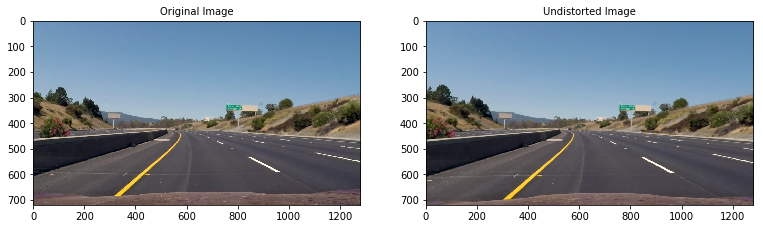

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
#axs = axs.ravel()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=10)
ax2.imshow(undist_img)
ax2.set_title('Undistorted Image', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

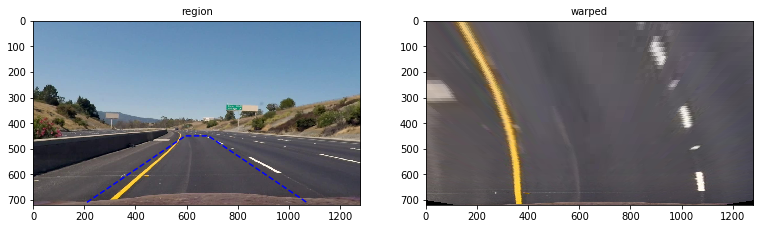

In [66]:
#Plot Warped image and region of interest
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
#axs = axs.ravel()
ax1.imshow(undist_img)
ax1.plot(region[0,:,0],region[0,:,1],'b--')
ax1.set_title('region', fontsize=10)
ax2.imshow(warped)
ax2.set_title('warped', fontsize=10)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

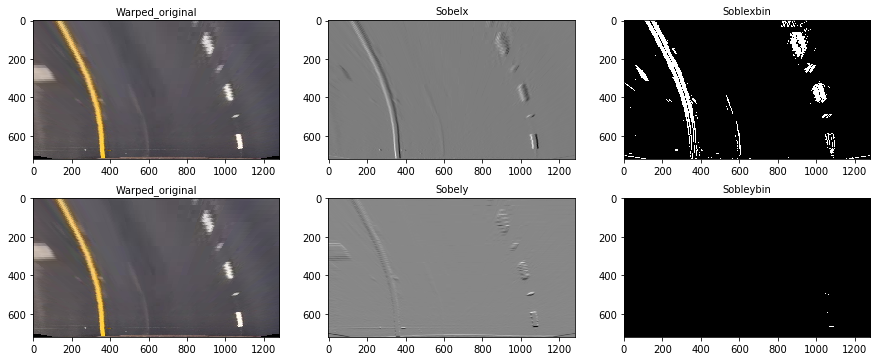

In [67]:
fig, axs = plt.subplots(2,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
axs[0].imshow(warped)
axs[0].set_title('Warped_original', fontsize=10)
axs[1].set_title('Sobelx', fontsize=10)
axs[1].imshow(sobelx,cmap='gray')
axs[2].set_title('Soblexbin', fontsize=10)
axs[2].imshow(sobelxbin,cmap='gray')
axs[3].imshow(warped)
axs[3].set_title('Warped_original', fontsize=10)
axs[4].set_title('Sobely', fontsize=10)
axs[4].imshow(sobely,cmap='gray')
axs[5].set_title('Sobleybin', fontsize=10)
axs[5].imshow(sobelybin,cmap='gray')

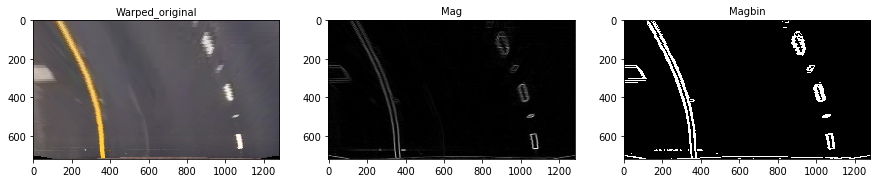

In [68]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

axs[0].imshow(warped)
axs[0].set_title('Warped_original', fontsize=10)
axs[1].imshow(mag,cmap='gray')
axs[1].set_title('Mag', fontsize=10)
axs[2].imshow(magbin,cmap='gray')
axs[2].set_title('Magbin', fontsize=10)
plt.imshow(magbin,cmap='gray')

Text(0.5,1,'Thetabin')

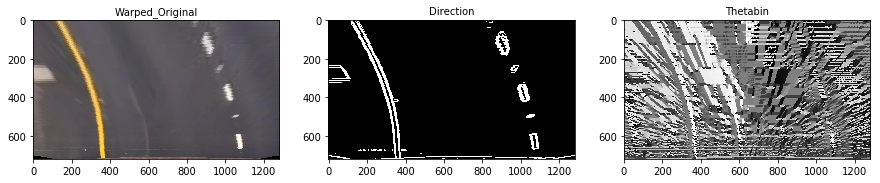

In [69]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

axs[0].imshow(warped)
axs[0].set_title('Warped_Original', fontsize=10)
axs[1].imshow(magbin,cmap='gray')
axs[1].set_title('Direction', fontsize=10)
axs[2].imshow(direction,cmap='gray')
axs[2].set_title('Thetabin', fontsize=10)

Text(0.5,1,'Combined')

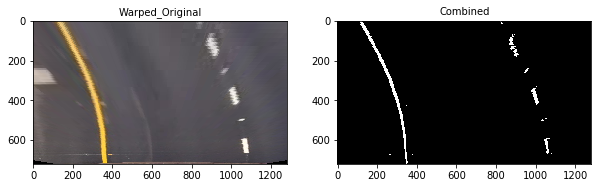

In [70]:
fig, axs = plt.subplots(1,2, figsize=(10, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()
axs[0].imshow(warped)
axs[0].set_title('Warped_Original', fontsize=10)
axs[1].imshow(combinedbin,cmap='gray')
axs[1].set_title('Combined', fontsize=10)

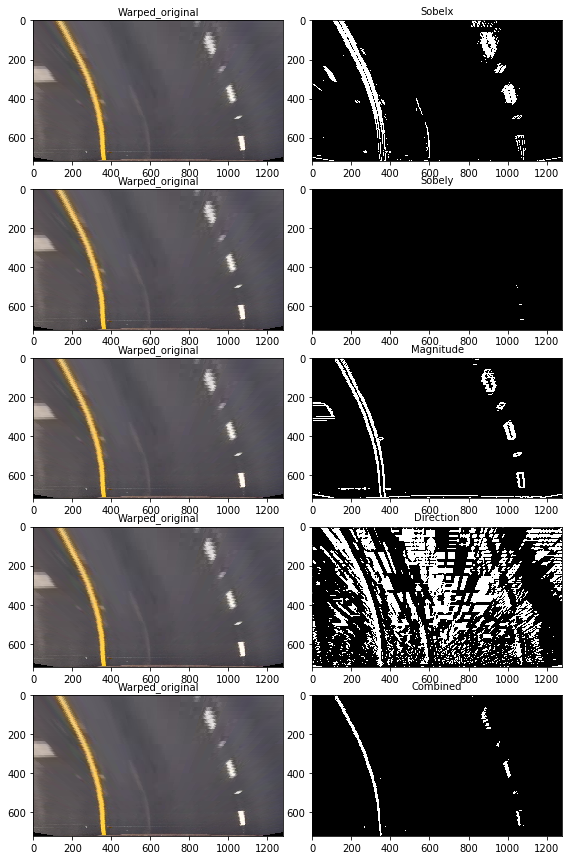

In [71]:
fig, axs = plt.subplots(5,2, figsize=(10, 15))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].imshow(warped)
axs[0].set_title('Warped_original', fontsize=10)
axs[1].imshow(sobelxbin,cmap='gray')
axs[1].set_title('Sobelx', fontsize=10)
axs[2].imshow(warped)
axs[2].set_title('Warped_original', fontsize=10)
axs[3].imshow(sobelybin,cmap='gray')
axs[3].set_title('Sobely', fontsize=10)
axs[4].imshow(warped)
axs[4].set_title('Warped_original', fontsize=10)
axs[5].imshow(magbin,cmap='gray')
axs[5].set_title('Magnitude', fontsize=10)
axs[6].imshow(warped)
axs[6].set_title('Warped_original', fontsize=10)
axs[7].set_title('Direction', fontsize=10)
axs[7].imshow(thetabin,cmap='gray')
axs[8].set_title('Warped_original', fontsize=10)
axs[8].imshow(warped)
axs[9].set_title('Combined', fontsize=10)
axs[9].imshow(combinedbin,cmap='gray')



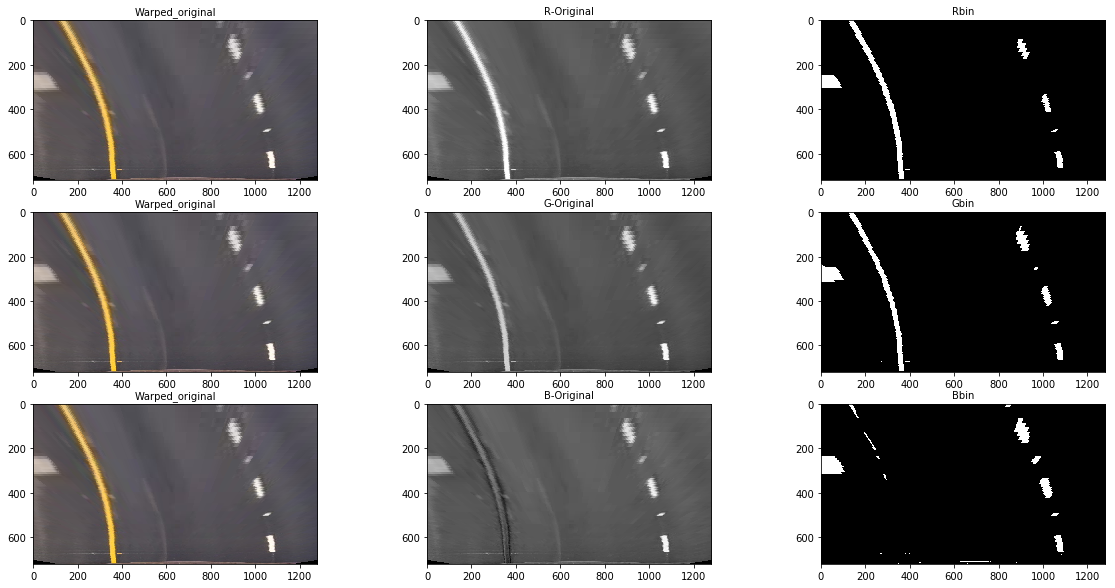

In [72]:
fig, axs = plt.subplots(3,3, figsize=(20, 10))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

axs[0].set_title('Warped_original', fontsize=10)
axs[0].imshow(warped)
axs[1].set_title('R-Original', fontsize=10)
axs[1].imshow(R,cmap='gray')
axs[2].set_title('Rbin', fontsize=10)
axs[2].imshow(Rbin,cmap='gray')
axs[3].set_title('Warped_original', fontsize=10)
axs[3].imshow(warped)
axs[4].set_title('G-Original', fontsize=10)
axs[4].imshow(G,cmap='gray')
axs[5].set_title('Gbin', fontsize=10)
axs[5].imshow(Gbin,cmap='gray')
axs[6].set_title('Warped_original', fontsize=10)
axs[6].imshow(warped)
axs[7].set_title('B-Original', fontsize=10)
axs[7].imshow(B,cmap='gray')
axs[8].set_title('Bbin', fontsize=10)
axs[8].imshow(Bbin,cmap='gray')



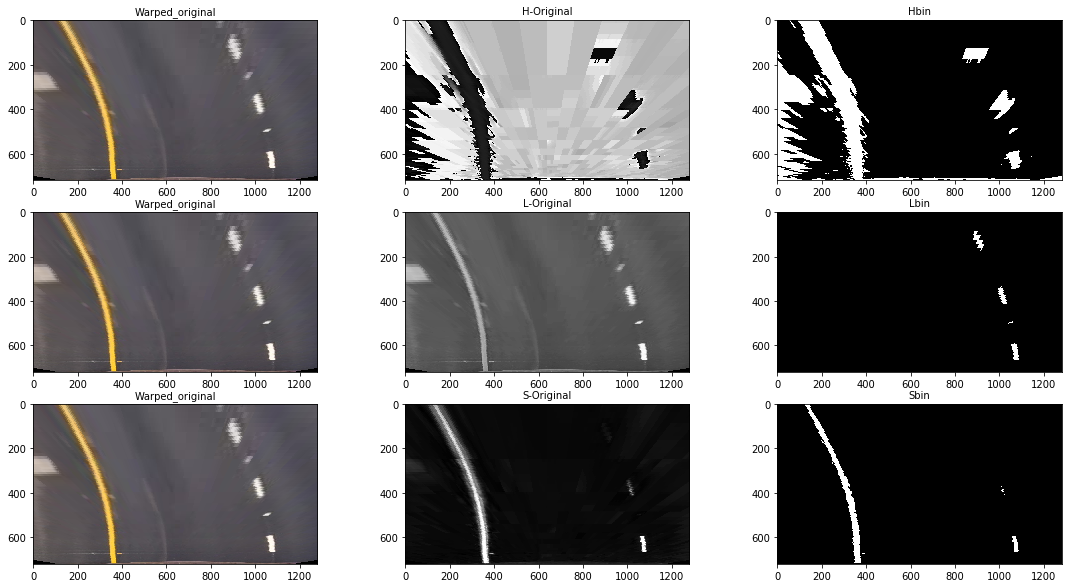

In [73]:
fig, axs = plt.subplots(3,3, figsize=(20, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].set_title('Warped_original', fontsize=10)
axs[0].imshow(warped)
axs[1].set_title('H-Original', fontsize=10)
axs[1].imshow(H,cmap='gray')
axs[2].set_title('Hbin', fontsize=10)
axs[2].imshow(Hbin,cmap='gray')
axs[3].set_title('Warped_original', fontsize=10)
axs[3].imshow(warped)
axs[4].set_title('L-Original', fontsize=10)
axs[4].imshow(L,cmap='gray')
axs[5].set_title('Lbin', fontsize=10)
axs[5].imshow(Lbin,cmap='gray')
axs[6].set_title('Warped_original', fontsize=10)
axs[6].imshow(warped)
axs[7].set_title('S-Original', fontsize=10)
axs[7].imshow(S,cmap='gray')
axs[8].set_title('Sbin', fontsize=10)
axs[8].imshow(Sbin,cmap='gray')

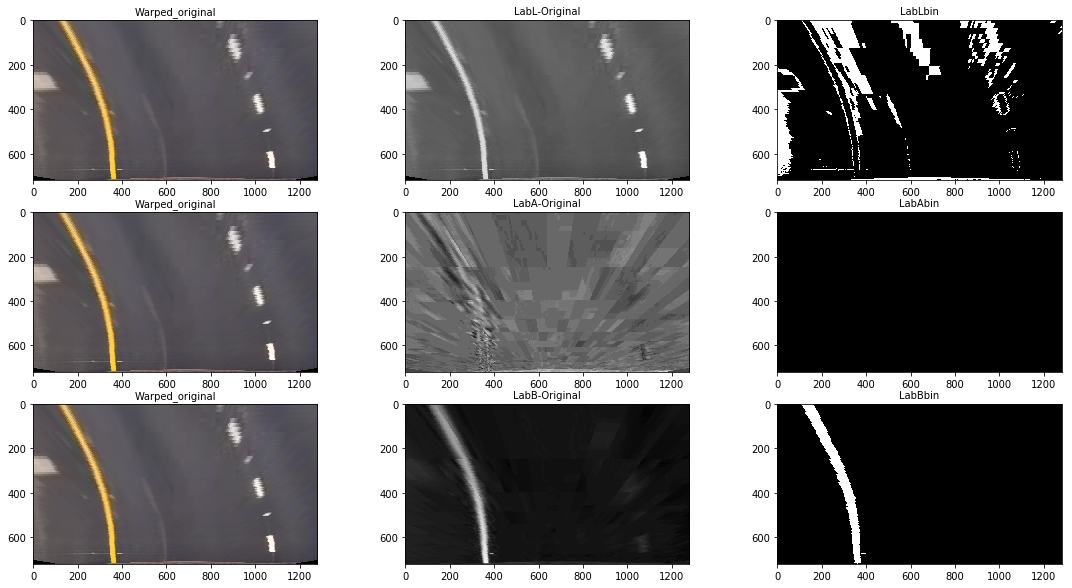

In [74]:
fig, axs = plt.subplots(3,3, figsize=(20, 10))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

axs[0].set_title('Warped_original', fontsize=10)
axs[0].imshow(warped)
axs[1].set_title('LabL-Original', fontsize=10)
axs[1].imshow(LabL,cmap='gray')
axs[2].set_title('LabLbin', fontsize=10)
axs[2].imshow(LabLbin,cmap='gray')
axs[3].set_title('Warped_original', fontsize=10)
axs[3].imshow(warped)
axs[4].set_title('LabA-Original', fontsize=10)
axs[4].imshow(LabA,cmap='gray')
axs[5].set_title('LabAbin', fontsize=10)
axs[5].imshow(LabAbin,cmap='gray')
axs[6].set_title('Warped_original', fontsize=10)
axs[6].imshow(warped)
axs[7].set_title('LabB-Original', fontsize=10)
axs[7].imshow(LabB,cmap='gray')
axs[8].set_title('LabBbin', fontsize=10)
axs[8].imshow(LabBbin,cmap='gray')

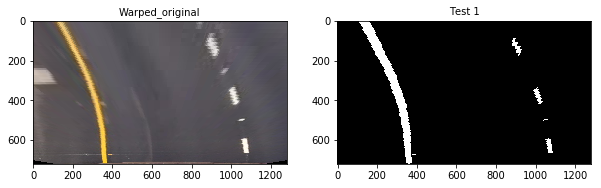

In [75]:
f, axs = plt.subplots(1, 2, figsize=(10, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

axs[0].set_title('Warped_original', fontsize=10)
axs[0].imshow(warped)
axs[1].set_title('Test 1', fontsize=10)
axs[1].imshow(testbin,cmap='gray')

640 349 1066


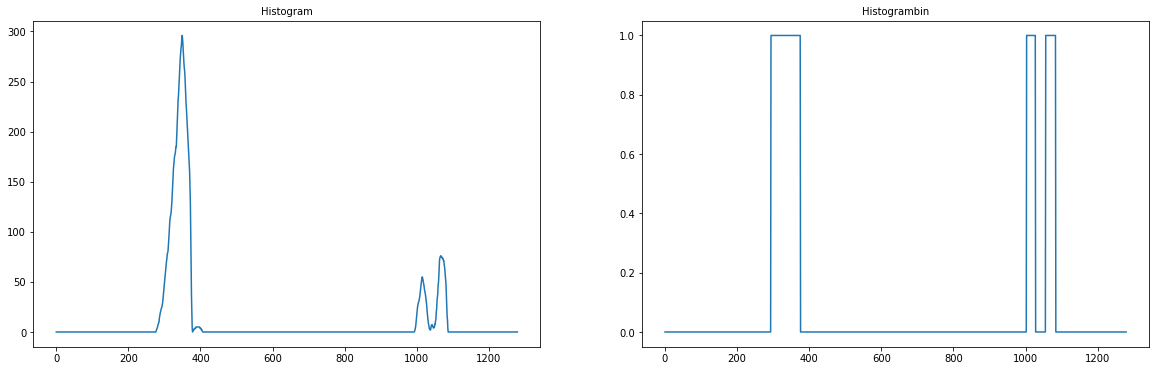

In [76]:
print(center,baseL,baseR)
f, axs = plt.subplots(1, 2, figsize=(20, 6))
fig.subplots_adjust(hspace = .2, wspace=.2)
axs = axs.ravel()

axs[0].set_title('Histogram', fontsize=10)
axs[0].plot(histogram)
axs[1].set_title('Histogrambin', fontsize=10)
axs[1].plot(histogrambin)

Done


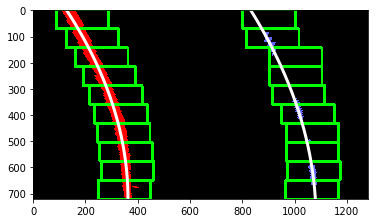

In [80]:
outbin = []
# Create an output image to draw on and  visualize the result
outbin = np.uint8(np.dstack((testbin, testbin, testbin))*255)

# Generate x and y values for plotting
ploty = np.linspace(0, testbin.shape[0]-1, testbin.shape[0])
lanexL = fitL[0]*ploty**2 + fitL[1]*ploty + fitL[2]
lanexR = fitR[0]*ploty**2 + fitR[1]*ploty + fitR[2]
outbin[laney[indexL], lanex[indexL]] = [255, 0, 0]
outbin[laney[indexR], lanex[indexR]] = [100, 100, 255]

for rect in windows:
# Draw the windows on the visualization image
    cv2.rectangle(outbin,(rect[2],rect[0]),(rect[3],rect[1]),(0,255,0), 10) 
    cv2.rectangle(outbin,(rect[4],rect[0]),(rect[5],rect[1]),(0,255,0), 10) 
# Identify the x and y positions of all nonzero pixels in the image

plt.imshow(outbin)
plt.plot(lanexL, ploty, color='white',linewidth= 3)
plt.plot(lanexR, ploty, color='white',linewidth = 3)
plt.xlim(0, X)
plt.ylim(Y, 0)
print('Done')

In [78]:
print(left_curverad, 'm', right_curverad, 'm')
print(curverad)
print(distfromcenter, 'm')

364.2622435179351 m 421.44609397660764 m
392.8541687472714
0.3567857142857143 m


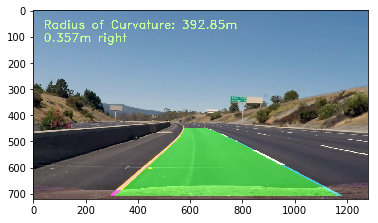

In [79]:
plt.imshow(final)

In [780]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

video_output1 = 'project_output.mp4'
video_input1 = VideoFileClip('project_video.mp4').subclip(0,50)
processed_video = video_input1.fl_image(videolanelinefind)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████▉| 1250/1251 [14:42<00:00,  1.44it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 15min 12s, sys: 59.2 s, total: 16min 11s
Wall time: 14min 43s


In [1]:
project_output = 'project_output.mp4'
from moviepy.editor import VideoFileClip
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))